# WangchanBERTa: Getting Started Notebook


This is a developing Getting Started Notebook for WangchanBERTa. Currently it has inference methods you can easily use from [HuggingFace](http://huggingface.co/). We will add pretraining and finetuning methods from the scripts in [vistec-ai/thai2transformers](https://github.com/vistec-AI/thai2transformers).

![WangchanBERTa](https://miro.medium.com/max/2400/1*XAHtR9rKv8SJ4ESELxm2iQ.png)

# Installation

Install dependencies at specific versions to make sure WangchanBERTa works.

In [1]:
# # Install thai2transformer 
# !pip -q install torch==1.5.0 torchtext==0.4.0 torchvision==0.6.0
# !pip -q install transformers==3.5.0 thai2transformers==0.1.2

In [2]:
# !pip install torch==1.4.0 

In [1]:
import torch

torch.cuda.is_available()

False

In [3]:
!python --version

Python 3.6.9 :: Anaconda, Inc.


In [4]:
import numpy as np
from tqdm.auto import tqdm
import torch

#datasets
# from datasets import load_dataset

#transformers
from transformers import (
    CamembertTokenizer,
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

#thai2transformers
import thai2transformers
from thai2transformers.preprocess import process_transformers
from thai2transformers.metrics import (
    classification_metrics, 
    multilabel_classification_metrics,
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

# Choose Pretrained Model

In this notebook, you can choose from 5 versions of WangchanBERTa, XLMR and mBERT to perform downstream tasks with Thai datasets. The datasets are:

* `wangchanberta-base-att-spm-uncased` (recommended) - Largest WangchanBERTa trained on 78.5GB of Assorted Thai Texts with subword tokenizer SentencePiece
* `xlm-roberta-base` - Facebook's [XLMR](https://arxiv.org/abs/1911.02116) trained on 100 languages
* `bert-base-multilingual-cased` - Google's [mBERT](https://arxiv.org/abs/1911.03310) trained on 104 languages
* `wangchanberta-base-wiki-newmm` - WangchanBERTa trained on Thai Wikipedia Dump with PyThaiNLP's word-level tokenizer  `newmm`
* `wangchanberta-base-wiki-syllable` - WangchanBERTa trained on Thai Wikipedia Dump with PyThaiNLP's syllabel-level tokenizer `syllable`
* `wangchanberta-base-wiki-sefr` - WangchanBERTa trained on Thai Wikipedia Dump with word-level tokenizer  `SEFR`
* `wangchanberta-base-wiki-spm` - WangchanBERTa trained on Thai Wikipedia Dump with subword-level tokenizer SentencePiece

In [5]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
#     'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
#     'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
#     'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
#     'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased'] 
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)


Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/282 [00:00<?, ?B/s]

# Masked Token Prediction

The simplest task for WangchanBERTa is the task it was trained on, that is, masked token prediction. The model will try to predict the masked token in a given sequence. For example:

> **Question**: วังจันทร์วัลเลย์ ตั้งอยู่บนพื้นที่ 3,454 `<mask>` ของอำเภอวังจันทร์ จังหวัดระยอง

> **Answer** [`ไร่`, `ตารางเมตร`, `กิโลเมตร`, `ตารางวา`, `ไมล์`]

We can use this to create more data for smaller datasets by substituting parts of the sequences; for instance, if you have 1,000 sequences, you can mask parts of each sequence and generate another 10,000 sentences for traning set. This has been proven to increase downstream performance such as the case of [AUG-BERT](https://link.springer.com/chapter/10.1007/978-981-13-9409-6_266) for English.

In [7]:
#pipeline
fill_mask = pipeline(task='fill-mask',
         tokenizer=tokenizer,
         model = f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
         revision = 'main',)

In [8]:
input_text = '\u0E02\u0E2D\u0E40\u0E07\u0E34\u0E19\u0E01\u0E39\u0E49\u003Cmask>\u0E2B\u0E19\u0E48\u0E2D\u0E22' #@param ['โครงการมีระยะทางทั้งหมด 114.3 <mask> มีจำนวนสถานี 36 สถานี เป็นเส้นทางหลักในแนวเหนือ–ใต้ ตามแนวทางรถไฟเดิมของการรถไฟแห่งประเทศไทย', 'วังจันทร์วัลเลย์ ตั้งอยู่บนพื้นที่ 3,454 <mask> ของอำเภอวังจันทร์ จังหวัดระยอง', 'ข้าวหน้าเนื้อ หรือเรียกเป็นภาษา<mask>ว่ากิวด้ง (Gyūdon)','จะไปเป็น<mask>โดดเด่นบนฟากฟ้า จะไปไขว่ขว้าเอามาดั่งใจฝัน', 'เช็คยอด<mask>', 'ขอเงินกู้<mask>หน่อย','กด<mask>ไม่ได้'] {allow-input: true}

preprocess_input_text = True #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(input_text)

#if the sequence is too short, it needs padding
def fill_mask_pad(input_text):
    return fill_mask(input_text+'<pad>')
#infer
fill_mask_pad(input_text)


[{'sequence': '<s> ขอเงินกู้นอกระบบ หน่อย</s>',
  'score': 0.13870617747306824,
  'token': 5682,
  'token_str': 'นอกระบบ'},
 {'sequence': '<s> ขอเงินกู้ในบัญชี หน่อย</s>',
  'score': 0.03802797198295593,
  'token': 10887,
  'token_str': 'ในบัญชี'},
 {'sequence': '<s> ขอเงินกู้ธนาคาร หน่อย</s>',
  'score': 0.02362395077943802,
  'token': 1045,
  'token_str': 'ธนาคาร'},
 {'sequence': '<s> ขอเงินกู้สหกรณ์ หน่อย</s>',
  'score': 0.02200942672789097,
  'token': 4501,
  'token_str': 'สหกรณ์'},
 {'sequence': '<s> ขอเงินกู้คืน หน่อย</s>',
  'score': 0.0209184680134058,
  'token': 561,
  'token_str': 'คืน'}]

# Sequence Classification

Multi-class sequence classification datasets such as:
* `wisesight_sentiment` - sentiment analysis from social media data provided by Wisesight
* `wongnai_reviews` - review classification from Wongnai.com

## Pretrained Multi-class Classifiers - Wisesight Sentiment and Wongnai Reviews

You can use our state-of-the-art finetuned WangchanBERTa for these tasks right away with:

In [9]:
#@title Choose Multi-class Classification Dataset
dataset_name = "wisesight_sentiment" #@param ['wisesight_sentiment','wongnai_reviews']

#pipeline
classify_multiclass = pipeline(task='sentiment-analysis',
         tokenizer=tokenizer,
         model = f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
         revision = f'finetuned@{dataset_name}')

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421M [00:00<?, ?B/s]

In [10]:
input_text = '\u0E40\u0E04\u0E22\u0E1A\u0E49\u0E32\u0E40\u0E2D\u0E47\u0E21\u0E40\u0E04\u0E01\u0E31\u0E1A\u0E41\u0E21\u0E48 \u0E01\u0E34\u0E19\u0E2D\u0E32\u0E17\u0E34\u0E15\u0E22\u0E4C\u0E25\u0E303-4 \u0E27\u0E31\u0E19\u0E15\u0E34\u0E14 \u0E42\u0E04\u0E15\u0E23\u0E2B\u0E19\u0E31\u0E01\u0E41\u0E25\u0E30\u0E42\u0E04\u0E15\u0E23\u0E40\u0E1B\u0E25\u0E37\u0E2D\u0E07\u0E07\u0E07\u0E07'  #@param ['อยากกินวะแก ซื้อมาให้หน่อยจิ', 'ขอบคุณแกมาก โคตรบ้าเลย', 'ฟอร์ด บุกตลาด อีวี ในอินเดีย #prachachat #ตลาดรถยนต์', 'สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเขียว มัชฉะลาเต้ร้อน รสชาเขียวเข้มข้น หอม มัน แต่ไม่กลมกล่อม มันจืดแบบจืดสนิท ส่วนไอศครีมชาเขียว ทานแล้วรสมันออกใบไม้ๆมากกว่าชาเขียว แล้วก็หวานไป โดยรวมแล้วเฉยมากก ดีแค่รสชาเขียวเข้ม มีน้ำเปล่าบริการฟรี','เคยบ้าเอ็มเคกับแม่ กินอาทิตย์ละ3-4 วันติด โคตรหนักและโคตรเปลืองงงง'] {allow-input: true}

preprocess_input_text = True #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(input_text)

#infer
classify_multiclass(input_text)

[{'label': 'neg', 'score': 0.9360982179641724}]

# Token Classification

We have state-of-the-art named entity recognition taggers based on both ThaiNER and LST20.

## Pretrained Token Classifiers - ThaiNER and LST20

In [11]:
#@title Choose Token Classification Dataset
dataset_name = "thainer" #@param ['thainer','lst20']

#pipeline
classify_tokens = pipeline(task='ner',
         tokenizer=tokenizer,
         model = f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
         revision = f'finetuned@{dataset_name}-ner',
         ignore_labels=[], 
         grouped_entities=True)

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

In [12]:
input_text = '\u0E42\u0E23\u0E07\u0E40\u0E23\u0E35\u0E22\u0E19\u0E2A\u0E27\u0E19\u0E01\u0E38\u0E2B\u0E25\u0E32\u0E1A\u0E40\u0E1B\u0E47\u0E19\u0E42\u0E23\u0E07\u0E40\u0E23\u0E35\u0E22\u0E19\u0E17\u0E35\u0E48\u0E14\u0E35 \u0E41\u0E15\u0E48\u0E44\u0E21\u0E48\u0E21\u0E35\u0E2A\u0E27\u0E19\u0E01\u0E38\u0E2B\u0E25\u0E32\u0E1A' #@param ['โรงเรียนสวนกุหลาบเป็นโรงเรียนที่ดี แต่ไม่มีสวนกุหลาบ', 'แดงเดือดรอบสอง ลิเวอร์พูล บุกเยือน แมนฯ ยูไนเต็ด', 'จีน-อินเดียเสี่ยงสูญเสียจากภัยธรรมชาติมากสุด', 'ทำให้ประชาชนกว่า 10,000 คน ต้องอพยพออกจากพื้นที่ อิทธิพลของพายุยังทำให้บ้านเรือนเกือบ 9,700 หลังพังถล่มลงมา สร้างความเสียหายคิดเป็นมูลค่า 450 ล้านหยวน','กทช.เตรียมทดลองประมูล 3จี 25 ก.ค.นี้']
preprocess_input_text = True #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(input_text)

#infer
classify_tokens(input_text)

[{'entity_group': 'ORGANIZATION', 'score': 0.782966673374176, 'word': ''},
 {'entity_group': 'ORGANIZATION',
  'score': 0.9278751015663147,
  'word': 'โรงเรียน'},
 {'entity_group': 'ORGANIZATION',
  'score': 0.9350615739822388,
  'word': 'สวนกุหลาบ'},
 {'entity_group': 'O',
  'score': 0.8276159550462451,
  'word': 'เป็นโรงเรียนที่ดี<_> แต่ไม่มีสวนกุหลาบ'}]

# Document Vectors

If the HuggingFace finetuners do not have what you are looking for, or you want to do something less traditional such as clustering using document vectors or simply use the document vectors for other classifiers such as logistic regression, random forest and gradient boosting.
![Image by @mrpeerat](https://miro.medium.com/max/1000/1*3JJRwT1f2zTK1hx36-qXdg.jpeg)

Image by [@mrpeerat](https://github.com/mrpeerat)

## Feature Extraction

We can use the outputs of WangchanBERTa (or any transformer-based models) as document vectors as an example by [BramVanroy](https://github.com/BramVanroy/bert-for-inference/blob/master/introduction-to-bert.ipynb).

![](https://github.com/BramVanroy/bert-for-inference/raw/ab7c57d6e7c79faf83ac0f9b6595c4b3d660c43c/img/bert-feature-extraction-contextualized-embeddings.png)

In [13]:
#pipeline
feature_extractor = pipeline(task='feature-extraction',
         tokenizer=tokenizer,
         model = f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
         revision = 'main')

def extract_last_k(input_text, feature_extractor, last_k=4):
    hidden_states = feature_extractor(input_text)[0]
    last_k_layers = [hidden_states[i] for i in [-i for i in range(1,last_k+1)]]
    cat_hidden_states = sum(last_k_layers, [])
    return np.array(cat_hidden_states)

You can see `I like Japanese food` and `I like gyudon` (as well as `I like Italian food` and `I like macaroni`) have high cosine similarity as they are considered "close" by WangchanBERTa.

<AxesSubplot:>

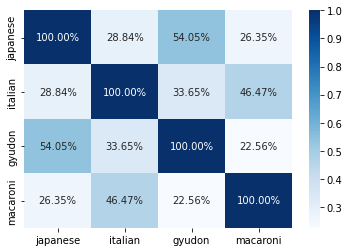

In [14]:
#@title Show similarity between Food and Country
text1 = 'ฉันชอบกินอาหารญี่ปุ่น' #@param {type:"raw"}
text2 = 'ฉันชอบกินอาหารอิตาเลียน' #@param {type:"raw"}
text3 = 'ฉันชอบกินกิวด้ง' #@param {type:"raw"}
text4 = 'ฉันชอบกินมักกะโรนี' #@param {type:"raw"}

t1 = extract_last_k(text1, feature_extractor)[None,:]
t2 = extract_last_k(text2, feature_extractor)[None,:]
t3 = extract_last_k(text3, feature_extractor)[None,:]
t4 = extract_last_k(text4, feature_extractor)[None,:]
ts = np.concatenate([t1,t2,t3,t4],0)

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
sim_matrix = cosine_similarity(ts,ts)
sns.heatmap(sim_matrix, annot=True, 
            fmt='.2%', cmap='Blues',
            xticklabels=['japanese','italian','gyudon','macaroni'],
            yticklabels=['japanese','italian','gyudon','macaroni'])

## Zero-shot Text Classification

Zero-shot text classification is a fancy way of saying "do similarity search with a given set of labels based on pretrained model outputs". It maybe useful when you do not have any training data to finetune at all. Here is how you can do it.

<br>

__Updated on Friday 26 March 2021__: We have released WanchanBERTa, XLMR and mBERT models finetuned on [XNLI](https://github.com/facebookresearch/XNLI) dataset ( Thai sentence pairs). The finetuned model checkpoints are stored under the branch named `finetuned@xnli_th` in our organization repositories (available at Huggingface Model Hub (https://huggingface.co/airesearch)).

In [16]:
#pipeline
zero_classify = pipeline(task='zero-shot-classification',
         tokenizer=tokenizer,
         model=AutoModelForSequenceClassification.from_pretrained(
             f'airesearch/{model_name}' if model_name not in public_models else f'airesearch/{model_name}-finetuned',
             revision='finetuned@xnli_th')
         )

Downloading:   0%|          | 0.00/421M [00:00<?, ?B/s]

In [17]:
input_text = "\u0E17\u0E35\u0E21\u0E44\u0E1A\u0E40\u0E14\u0E19\u0E2B\u0E32\u0E23\u0E37\u0E2D\u0E01\u0E31\u0E1A\u0E0D\u0E35\u0E48\u0E1B\u0E38\u0E48\u0E19 \u0E01\u0E23\u0E30\u0E0A\u0E31\u0E1A\u0E04\u0E27\u0E32\u0E21\u0E40\u0E1B\u0E47\u0E19\u0E1E\u0E31\u0E19\u0E18\u0E21\u0E34\u0E15\u0E23" #@param ["SCB 10X \u0E23\u0E48\u0E27\u0E21\u0E25\u0E07\u0E17\u0E38\u0E19\u0E43\u0E19 BlockFi Startup \u0E14\u0E49\u0E32\u0E19 Digital Asset", "\u0E2D\u0E32\u0E40\u0E1A\u0E30\u0E1B\u0E23\u0E31\u0E1A\u0E04\u0E13\u0E30\u0E23\u0E31\u0E10\u0E21\u0E19\u0E15\u0E23\u0E35\u0E0D\u0E35\u0E48\u0E1B\u0E38\u0E48\u0E19 \u0E15\u0E31\u0E49\u0E07 \u201C\u0E23\u0E21\u0E15.\u0E01\u0E25\u0E32\u0E42\u0E2B\u0E21\u201D \u0E04\u0E19\u0E43\u0E2B\u0E21\u0E48", "WangchanBERTa \u0E42\u0E21\u0E40\u0E14\u0E25\u0E1B\u0E23\u0E30\u0E21\u0E27\u0E25\u0E1C\u0E25\u0E20\u0E32\u0E29\u0E32\u0E44\u0E17\u0E22\u0E17\u0E35\u0E48\u0E43\u0E2B\u0E0D\u0E48\u0E41\u0E25\u0E30\u0E01\u0E49\u0E32\u0E27\u0E2B\u0E19\u0E49\u0E32\u0E17\u0E35\u0E48\u0E2A\u0E38\u0E14\u0E43\u0E19\u0E02\u0E13\u0E30\u0E19\u0E35\u0E49", "\u201CWhere We Belong\" \u0E04\u0E27\u0E49\u0E32\u0E20\u0E32\u0E1E\u0E22\u0E19\u0E15\u0E23\u0E4C\u0E22\u0E2D\u0E14\u0E40\u0E22\u0E35\u0E48\u0E22\u0E21 \u0E2A\u0E38\u0E1E\u0E23\u0E23\u0E13\u0E2B\u0E07\u0E2A\u0E4C\u0E04\u0E23\u0E31\u0E49\u0E07\u0E17\u0E35\u0E48 29", "\u0E17\u0E35\u0E21\u0E44\u0E1A\u0E40\u0E14\u0E19\u0E2B\u0E32\u0E23\u0E37\u0E2D\u0E01\u0E31\u0E1A\u0E0D\u0E35\u0E48\u0E1B\u0E38\u0E48\u0E19 \u0E01\u0E23\u0E30\u0E0A\u0E31\u0E1A\u0E04\u0E27\u0E32\u0E21\u0E40\u0E1B\u0E47\u0E19\u0E1E\u0E31\u0E19\u0E18\u0E21\u0E34\u0E15\u0E23", "\u0E19\u0E31\u0E01\u0E27\u0E34\u0E08\u0E31\u0E22\u0E19\u0E32\u0E42\u0E19\u0E40\u0E17\u0E04\u0E42\u0E19\u0E42\u0E25\u0E22\u0E35 \u0E08\u0E32\u0E01\u0E2A\u0E16\u0E32\u0E1A\u0E31\u0E19\u0E27\u0E34\u0E17\u0E22\u0E2A\u0E34\u0E23\u0E34\u0E40\u0E21\u0E18\u0E35 \u0E1C\u0E39\u0E49\u0E04\u0E34\u0E14\u0E04\u0E49\u0E19\u0E41\u0E1A\u0E15\u0E40\u0E15\u0E2D\u0E23\u0E35\u0E48\u0E08\u0E32\u0E01\u0E27\u0E31\u0E2A\u0E14\u0E38\u0E01\u0E23\u0E32\u0E1F\u0E35\u0E19 \u0E04\u0E27\u0E49\u0E32\u0E23\u0E32\u0E07\u0E27\u0E31\u0E25\u0E19\u0E31\u0E01\u0E27\u0E34\u0E17\u0E22\u0E32\u0E28\u0E32\u0E2A\u0E15\u0E23\u0E4C\u0E14\u0E35\u0E40\u0E14\u0E48\u0E19 \u0E1B\u0E23\u0E30\u0E08\u0E33\u0E1B\u0E35 2562 ", "\u0E1E\u0E34\u0E1E\u0E34\u0E18\u0E20\u0E31\u0E13\u0E11\u0E4C\u0E1D\u0E23\u0E31\u0E48\u0E07\u0E40\u0E28\u0E2A\u0E40\u0E1C\u0E22\u0E41\u0E1E\u0E23\u0E48\u0E44\u0E1F\u0E25\u0E4C\u0E14\u0E34\u0E08\u0E34\u0E17\u0E31\u0E25\u0E20\u0E32\u0E1E\u0E27\u0E32\u0E14 \u0E20\u0E32\u0E1E\u0E16\u0E48\u0E32\u0E22 \u0E41\u0E25\u0E30\u0E20\u0E32\u0E1E\u0E1B\u0E23\u0E30\u0E01\u0E2D\u0E1A\u0E2B\u0E19\u0E31\u0E07\u0E2A\u0E37\u0E2D\u0E43\u0E19\u0E2D\u0E14\u0E35\u0E15 \u0E23\u0E27\u0E21\u0E01\u0E27\u0E48\u0E32 1 \u0E41\u0E2A\u0E19\u0E23\u0E39\u0E1B "] {allow-input: true}

preprocess_input_text = True #@param {type:"boolean"}
if preprocess_input_text:
    if model_name not in public_models:
        input_text = process_transformers(input_text)

#infer
zero_classify(input_text, 
              candidate_labels=['เศรษฐกิจ-ธุรกิจ','การเมือง',
                                'เทคโนโลยี', 'ศิลปะ-บันเทิง'],
              hypothesis_template='พาดหัวข่าวนี้้เกี่ยวกับ{}')

{'sequence': 'ทีมไบเดนหารือกับญี่ปุ่น<_>กระชับความเป็นพันธมิตร',
 'labels': ['การเมือง', 'เทคโนโลยี', 'ศิลปะ-บันเทิง', 'เศรษฐกิจ-ธุรกิจ'],
 'scores': [0.39383983612060547,
  0.2437462955713272,
  0.20734050869941711,
  0.15507344901561737]}